In [1]:
import time
import os

import scanpy as sc
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import models.loadImg as loadImg
import models.modelsCNN as modelsCNN
import models.optimizer as optimizer

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
from skimage import io
import umap
from sklearn.cluster import MiniBatchKMeans,AgglomerativeClustering
from sklearn.decomposition import PCA

import anndata as ad

In [2]:
sc.settings.verbosity = 3



In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "0,1,2,3" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" 
use_cuda=True


In [4]:
radius=48
datadir='/media/xinyi/dcis2idc/data'
sampleList=[]
for s in os.listdir('/media/xinyi/dcis2idc/data'):
    if 'hoechst'  in s and ('_1_' in s or '_3_' in s or '_4_' in s or '_6_' in s):
#     if 'hoechst'  in s and ('_3_' in s or '_4_' in s or '_6_' in s):
        sampleList.append(s)
print(sampleList)
trainingCores={'br1003a':[],'br8018a':[],'br301':[]}
for s in range(1,11):
# for s in range(5,11):
    trainingCores['br1003a'].append('A'+str(s))
    trainingCores['br1003a'].append('C'+str(s))
    trainingCores['br1003a'].append('I'+str(s))
for s in range(1,11):
    if s<9:
        trainingCores['br8018a'].append('H'+str(s))
    trainingCores['br8018a'].append('A'+str(s))
    trainingCores['br8018a'].append('B'+str(s))
    trainingCores['br8018a'].append('F'+str(s))
for s in range(1,7):
    for sr in ['A','B','C','D','E']:
        trainingCores['br301'].append(sr+str(s))

['br1003a_1_cytokeratin_555_aSMA_647_hoechst', 'br1003a_3_collagen1_647_hoechst', 'br1003a_4_cytokeratin_555_gh2ax_647_hoechst', 'br301_4_cytokeratin_555_aSMA_647_hoechst', 'br301_6_collagen1_647_hoechst', 'br8018a_1_cytokeratin_555_aSMA_647_hoechst', 'br8018a_3_collagen1_647_hoechst', 'br8018a_4_cytokeratin_555_gh2ax_647_hoechst']


In [5]:
with open(os.path.join(datadir,'processed','latent311'), 'rb') as input:
    latent=pickle.load(input)

In [6]:
name='exp0'
logsavepath='/media/xinyi/dcis2idc/log/cnnvae'+name
modelsavepath='/media/xinyi/dcis2idc/models/cnnvae'+name
plotsavepath='/media/xinyi/dcis2idc/plots/cnnvae'+name
clustersavedir=os.path.join(plotsavepath,'cluster_reordered')
if not os.path.exists(clustersavedir):
    os.mkdir(clustersavedir)

In [7]:
ep=311

In [8]:
with open(os.path.join(datadir,'processed','train_cnnvae_names'), 'rb') as input:
    allImgNames=pickle.load(input)
#plot by disease progression
br1003aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR1003a specs.xlsx',header=10)
br301Specs=pd.read_excel('/media/xinyi/dcis2idc/data/BR301 specs.xlsx',header=10)
br8018aSpecs=pd.read_excel('/media/xinyi/dcis2idc/data/BR8018a specs.xlsx',header=10)
br1003aSpecs.index=br1003aSpecs.loc[:,'Position']
br301Specs.index=br301Specs.loc[:,'Position']
br8018aSpecs.index=br8018aSpecs.loc[:,'Position']

progList=np.copy(allImgNames)
for s in np.unique(allImgNames):
    ssplit=s.split('_')
    if 'br1003a'==ssplit[0]:
        prog_s=br1003aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br301'==ssplit[0]:
        prog_s=br301Specs.loc[(ssplit[-1],'Pathology diagnosis')]
    elif 'br8018a'==ssplit[0]:
        prog_s=br8018aSpecs.loc[(ssplit[-1],'Pathology diagnosis')]
    progList[allImgNames==s]=prog_s
    
progNames,progCounts=np.unique(progList,return_counts=True)
progSampleRate={}
for p in range(progNames.size):
    progSampleRate[progNames[p]]=np.min(progCounts)/progCounts[p]
    
    
np.random.seed(6)
# plotPCT=4500
plottingIdx_i=np.array([])
n_pcs=50
uniqueImgNames,imgNameIdx=np.unique(allImgNames,return_index=True)
for i in range(1):
    for sidx in range(uniqueImgNames.size):
        s=uniqueImgNames[sidx]
        p=progList[imgNameIdx[sidx]]
        print(s+' '+p)
        nsamples=int(np.sum(allImgNames==s)*progSampleRate[p])
        plottingIdx_i=np.concatenate((plottingIdx_i,
                                    np.random.choice(np.arange(allImgNames.shape[0])[allImgNames==s],nsamples,replace=False)))



br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2 Hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6 Atypical hyperplasia
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7 Hyperplasia
br1003a_1_cytokeratin_555_

br301_6_collagen1_647_hoechst_D2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_D4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_D5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_D6 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E1 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E2 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E3 Invasive ductal carcinoma and breast tissue
br301_6_collagen1_647_hoechst_E4 Invasive ductal carcinoma
br301_6_collagen1_647_hoechst_E5 Ductal carcinoma in situ with early infiltratio
br301_6_collagen1_647_hoechst_E6 Ductal carcinoma in situ with early infiltratio
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1 Invasive ductal carcinoma
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10 Invasive ductal carcinoma
br8018a_1_cytoke

### initial run with the basic setup

In [10]:
sc.settings.verbosity = 3
latent_adata=ad.AnnData(latent[plottingIdx_i.astype(int)])
latent_adata.obs['prog']=progList[plottingIdx_i.astype(int)]
latent_adata.obs['allImgNames']=allImgNames[plottingIdx_i.astype(int)]
plotepoch=311
plotsavenameAdd='_plottingIdx_progBalanced_'+str(0)+'_reordered'
ncluster=8
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+plotsavenameAdd
with open(os.path.join(plotsavepath,'cluster',savenamecluster), 'rb') as output:
    latent_adata.obs['kmeans'+str(ncluster)]=pickle.load(output)
latent_adata.obs['kmeans'+str(ncluster)]=latent_adata.obs['kmeans'+str(ncluster)].astype('category')
latent_adata.obs['prog']=latent_adata.obs['prog'].astype('category')   

<ipython-input-10-736cc8919aa2>:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_adata=ad.AnnData(latent[plottingIdx_i.astype(int)])


In [11]:

sc.tl.pca(latent_adata, svd_solver='arpack')
sc.pp.neighbors(latent_adata, n_neighbors=4, n_pcs=20)
# sc.tl.draw_graph(latent_adata,layout='lgl')
# sc.pl.draw_graph(latent_adata,color='kmeans8',legend_loc='on data')

computing PCA
    with n_comps=50
    finished (0:00:27)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


In [12]:
np.random.seed(3)
sc.tl.paga(latent_adata, groups='kmeans8')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)


--> added 'pos', the PAGA positions (adata.uns['paga'])


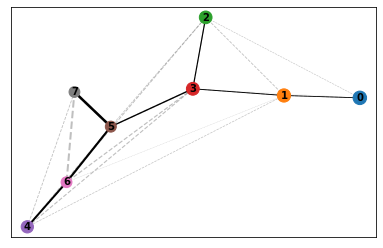

In [13]:
sc.pl.paga(latent_adata, color=['kmeans8'],solid_edges='connectivities_tree',
    dashed_edges='connectivities')

--> added 'pos', the PAGA positions (adata.uns['paga'])


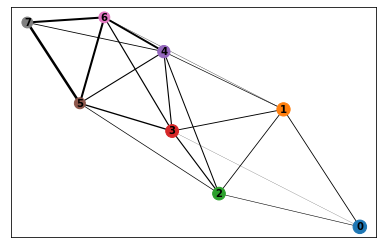

In [14]:
sc.pl.paga(latent_adata, color=['kmeans8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


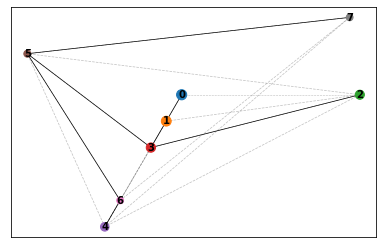

In [15]:
sc.pl.paga(latent_adata, color=['kmeans8'],solid_edges='connectivities_tree',
    dashed_edges='connectivities',layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=10)

#### random samples

0
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


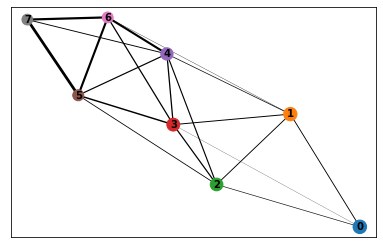

1
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


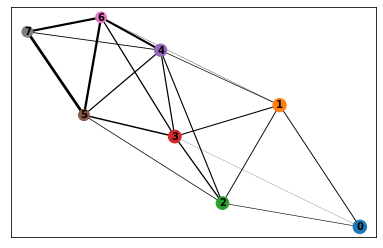

2
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


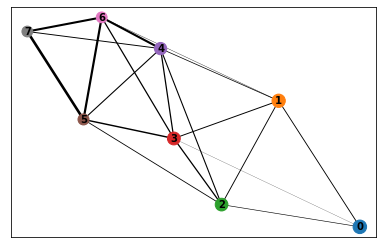

3
computing PCA
    with n_comps=50
    finished (0:00:40)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


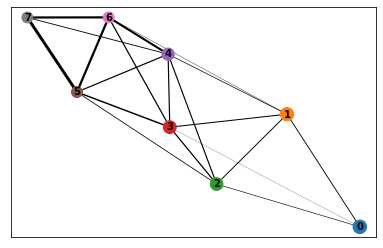

4
computing PCA
    with n_comps=50
    finished (0:00:31)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


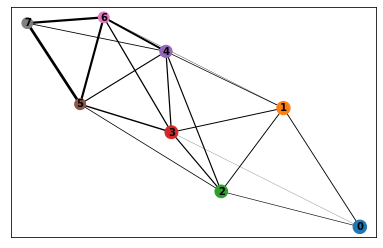

5
computing PCA
    with n_comps=50
    finished (0:00:24)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


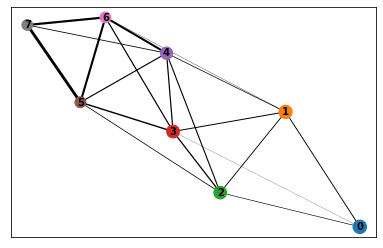

6
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


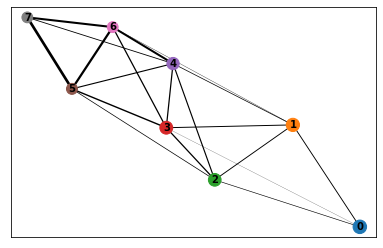

7
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


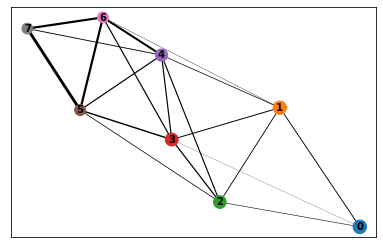

8
computing PCA
    with n_comps=50
    finished (0:00:50)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


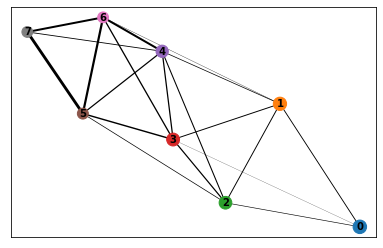

9
computing PCA
    with n_comps=50
    finished (0:00:44)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


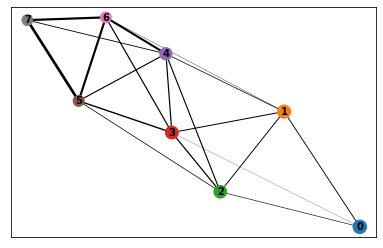

10
computing PCA
    with n_comps=50
    finished (0:00:34)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


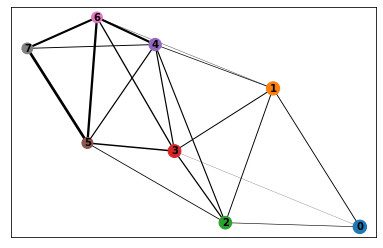

11
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


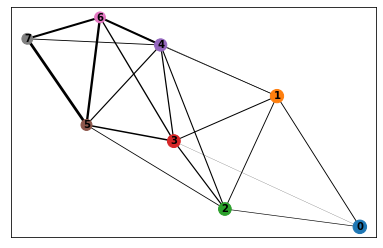

12
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


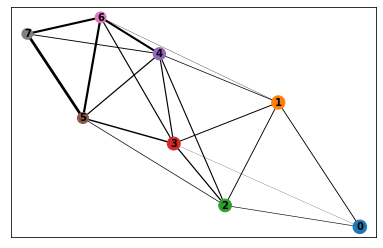

13
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


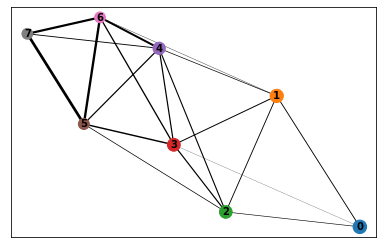

14
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


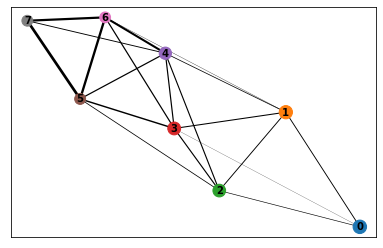

15
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


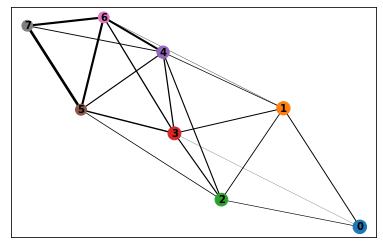

16
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


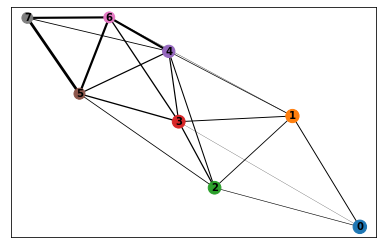

17
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


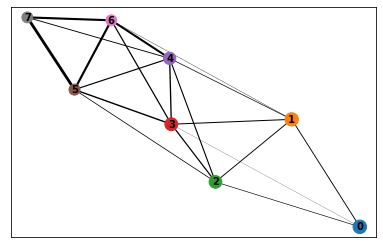

18
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


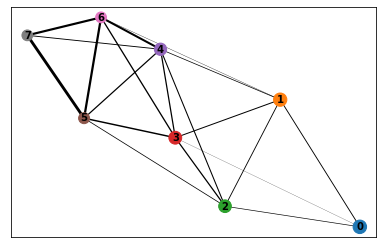

19
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:01)
--> added 'pos', the PAGA positions (adata.uns['paga'])


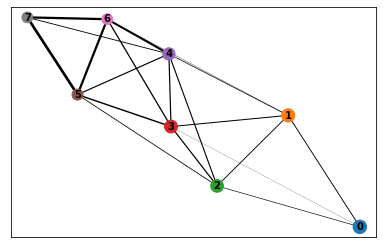

In [16]:
np.random.seed(6)
nRandomsamples=20
sampleRate=0.5
for n in range(nRandomsamples):
    print(n)
    latent_adatasample=latent_adata[np.random.choice(latent_adata.shape[0],int(latent_adata.shape[0]*sampleRate),replace=False)]
    sc.tl.pca(latent_adatasample, svd_solver='arpack')
    sc.pp.neighbors(latent_adatasample, n_neighbors=4, n_pcs=20)
    sc.tl.paga(latent_adatasample, groups='kmeans8')
    sc.pl.paga(latent_adatasample, color=['kmeans8'])
    plt.show()

### combine subclusters to same trajectory

In [62]:
neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
sc.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
plotsavenameAdd='_plottingIdx_progBalanced_'+str(0)+'_reordered'
savenamecluster0='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(plotsavepath,'cluster',savenamecluster0+plotsavenameAdd), 'rb') as output:
    clusterRes=pickle.load(output)
latent_adata=ad.AnnData(latent[plottingIdx_i.astype(int)])
kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
for c in np.unique(clusterRes):
    print('cluster'+str(c))
    for subcluster in subclusterDict[neworder[c]]:
        subclustersavedir=os.path.join(plotsavepath,'cluster',savenamecluster0+'_plottingIdx_progBalanced_'+str(0)+'_subcluster'+str(neworder[c]))
#         latent_adata=ad.AnnData(latent[plottingIdx_i.astype(int)][clusterRes==c])

        savenamecluster='minibatchkmean_ncluster'+str(subcluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_plottingIdx_progBalanced_'+str(0)
        with open(os.path.join(subclustersavedir,savenamecluster), 'rb') as output:
            subclusterRes=pickle.load(output)

        kmeans_sub[clusterRes==c]=np.char.add(np.repeat(str(c)+'-',subclusterRes.size),subclusterRes.astype(str))
        
latent_adata.obs['kmeans_sub']=kmeans_sub
latent_adata.obs['kmeans_sub']=latent_adata.obs['kmeans_sub'].astype('category')
latent_adata.obs['kmeans']=clusterRes.astype(str)
latent_adata.obs['kmeans']=latent_adata.obs['kmeans'].astype('category')


subclusterplotdir=os.path.join(clustersavedir,savenamecluster0+plotsavenameAdd+'_subcluster_all')
if not os.path.exists(subclusterplotdir):
    os.mkdir(subclusterplotdir)


sc.settings.figdir=os.path.join(subclusterplotdir)

np.random.seed(3)
sc.tl.pca(latent_adata, svd_solver='arpack')
sc.pp.neighbors(latent_adata, n_neighbors=4, n_pcs=20)
sc.tl.paga(latent_adata, groups='kmeans_sub')
# plt.rcParams["figure.figsize"] = (10, 10)
# plt.rcParams['figure.dpi'] = 1200
# # sc.pl.paga(latent_adata, color=['kmeans'],save=None,threshold=0.01,show=False,random_state=6)
# # sc.pl.paga(latent_adata, color=['kmeans'],save='graph.png') #default threshold is 0.01
# sc.pl.paga(latent_adata, color=['kmeans'],save='graph_thresh001.png',threshold=0.01,show=False,random_state=6)
# sc.tl.umap(latent_adata, init_pos='paga')
# sc.pl.umap(latent_adata,color=['kmeans'],legend_loc='on data',save='graph_umap.png',show=False)



# sc.pl.paga(latent_adata, color=['kmeans'],solid_edges='connectivities_tree',
#     dashed_edges='connectivities',layout='rt_circular',
#     node_size_scale=0.5,
#     node_size_power=0.9,
#     max_edge_width=0.7,
#     fontsize=10,
#     save='tree_thresh001.png',threshold=0.01,show=False,random_state=6)
# sc.tl.umap(latent_adata, init_pos='paga')
# sc.pl.umap(latent_adata,color=['kmeans'],legend_loc='on data',save='tree_umap.png',show=False)




<ipython-input-62-24016a6321c1>:13: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_adata=ad.AnnData(latent[plottingIdx_i.astype(int)])


cluster0
cluster1
cluster2
cluster3
cluster4
cluster5
cluster6
cluster7
computing PCA
    with n_comps=50
    finished (0:00:30)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:18)


In [11]:
latent_adata.uns['paga']['pos'].shape

(46, 2)

In [12]:
with open(os.path.join(subclusterplotdir,'pagaPos_reordered'), 'wb') as output:
    pickle.dump(latent_adata.uns['paga']['pos'], output, pickle.HIGHEST_PROTOCOL)

In [21]:
#random subsamples
n=20

np.random.seed(6)
nRandomsamples=20
sampleRate=0.5
for n in range(nRandomsamples):
    print(n)
    latent_adata_sub=latent_adata[np.random.choice(latent_adata.shape[0],int(latent_adata.shape[0]*sampleRate),replace=False)]


    sc.tl.pca(latent_adata_sub, svd_solver='arpack')
    sc.pp.neighbors(latent_adata_sub, n_neighbors=4, n_pcs=20)
    sc.tl.paga(latent_adata_sub, groups='kmeans_sub')
    sc.pl.paga(latent_adata_sub, color=['kmeans'],save='graph_random'+str(n)+'.png',show=False)

    sc.pl.paga(latent_adata_sub, color=['kmeans'],solid_edges='connectivities_tree',
        dashed_edges='connectivities',layout='rt_circular',
        node_size_scale=0.5,
        node_size_power=0.9,
        max_edge_width=0.7,
        fontsize=10,
        save='tree_random'+str(n)+'.png', show=False)


0
computing PCA
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:09)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
1
computing PCA
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivitie

--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
9
computing PCA
    with n_comps=50
    finished (0:00:16)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:09)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
10
computing PCA
    with n_comps=50
    finished (0:00:18)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: ad

17
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:09)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
18
computing PCA
    with n_comps=50
    finished (0:00:17)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivit

#### color gradient by proteins

In [33]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)

In [11]:
stats2plot=['int_median','kurtosis','skewness','int_mode','entropy']
stains=['aSMA','cytokeratin','collagen1','gh2ax']
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

ncluster=8
plotepoch=311
    
allstats=None
alllabels=None
allvarnames=None

allidx=None
idx_temp=np.arange(plottingIdx_i.size)
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]

    print(s)
    assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
    slabels=kmeans_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    sidx=idx_temp[allImgNames[plottingIdx_i.astype(int)]==s]
    for stain_s in stains:
        if not stain_s in s:
            continue
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'cellular_'+stain_s.lower(),s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(stain_s)
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
        if allstats is None:
            allstats=stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()
            alllabels=np.copy(slabels)
            allvarnames=np.repeat(stain_s,slabels.size)
            allidx=np.copy(sidx)
        else:
            allstats=np.concatenate((allstats,stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()),axis=0)
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
            allvarnames=np.concatenate((allvarnames,np.repeat(stain_s,slabels.size)))
            allidx=np.concatenate((allidx,sidx))
            
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C5
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C6
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C7
aSMA
cyt

br8018a_1_cytokeratin_555_aSMA_647_hoechst_B2
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B3
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B4
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B5
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B6
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B7
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_B8
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F1
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F10
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F2
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F3
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F4
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F5
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F6
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F7
aSMA
cytokeratin
br8018a_1_cytokeratin_555_aSMA_647_hoechst_F8
aSMA
cyt

In [17]:
#thresh=1
nneighbors_list=[4,10,20] 

for nneighbors in nneighbors_list:
    for v in np.unique(allvarnames):
        plotidx=allidx[allvarnames==v]
        latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])
        latent_prot.obs['kmeans_sub']=alllabels[allvarnames==v]
        latent_prot.obs['protein']=allstats[allvarnames==v,0]
        latent_prot.obs['kmeans_sub']=latent_prot.obs['kmeans_sub'].astype('category')

        sc.settings.figdir=os.path.join(subclusterplotdir)

        sc.tl.pca(latent_prot, svd_solver='arpack')
        sc.pp.neighbors(latent_prot, n_neighbors=nneighbors, n_pcs=20)
        sc.tl.paga(latent_prot, groups='kmeans_sub')
        plt.rcParams["figure.figsize"] = (10, 10)
        sc.pl.paga(latent_prot, color=['protein'],save='graph'+v+'_neighbors'+str(nneighbors)+'.png',show=False,random_state=6)

        sc.pl.paga(latent_prot, color=['protein'],solid_edges='connectivities_tree',
            dashed_edges='connectivities',layout='rt_circular',
            node_size_scale=0.5,
            node_size_power=0.9,
            max_edge_width=0.7,
            fontsize=10,
            save='tree'+v+'_neighbors'+str(nneighbors)+'.png',show=False,random_state=6)

<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:08)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:10)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:06)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:11)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:08)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:07)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:11)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing PCA
    with n_comps=50


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


    finished (0:00:05)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:02)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:09)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:11)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:08)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


computing PCA
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:12)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing PCA
    with n_comps=50


<ipython-input-17-41c5a3423e6c>:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])


    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:03)
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


In [18]:
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
#log scale
#thresh=1
# nneighbors_list=[4,10] 

for v in np.unique(allvarnames):
    plotidx=allidx[allvarnames==v]
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[plotidx]=np.log(allstats[allvarnames==v,0]+1)
    latent_adata.obs[v+'log']=protvalues
#         latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])
#         latent_prot.obs['kmeans_sub']=alllabels[allvarnames==v]
#         latent_prot.obs['protein']=allstats[allvarnames==v,0]
#         latent_prot.obs['kmeans_sub']=latent_prot.obs['kmeans_sub'].astype('category')

    sc.settings.figdir=os.path.join(subclusterplotdir)

    sc.pl.paga(latent_adata, color=[v+'log'],save='graph'+v+'_allcells_log.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v+'log'],legend_loc='on data',save='graph_umap'+v+'_log.png',show=False,size=3)

 

    sc.pl.paga(latent_adata, color=[v+'log'],solid_edges='connectivities_tree',
        dashed_edges='connectivities',layout='rt_circular',
        node_size_scale=0.5,
        node_size_power=0.9,
        max_edge_width=0.7,
        fontsize=10,
        save='tree'+v+'_allcells_log.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v+'log'],legend_loc='on data',save='tree_umap'+v+'_log.png',show=False)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:42)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.o

In [18]:
#by pathology
#changed paga plotting function to enable vmax and vmin
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
#log scale
#thresh=1
# nneighbors_list=[4,10] 
latent_adata.obs['prog']=progList[plottingIdx_i.astype(int)]
vminlist={'aSMA':6.6,'collagen1':7.1,'cytokeratin':6.55,'gh2ax':6.6}
vmaxlist={'aSMA':7.8,'collagen1':8.61,'cytokeratin':8.7,'gh2ax':8.4}
for v in np.unique(allvarnames):
    vmin=vminlist[v]
    vmax=vmaxlist[v]
    for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs[v+'log'])]):
        vprog=v+'_log_'+prog
        plotidx=allidx[allvarnames==v]
        protvalues=np.repeat(np.nan,latent_adata.shape[0])
        protvalues[plotidx]=np.log(allstats[allvarnames==v,0]+1)
        protvalues[latent_adata.obs['prog']!=prog]=np.nan
        latent_adata.obs[vprog]=protvalues

        sc.settings.figdir=os.path.join(subclusterplotdir)

        sc.pl.paga(latent_adata, color=[vprog],save='graph'+vprog+'_allcells.png',show=False,random_state=6,vmin=vmin,vmax=vmax,cmap='jet')
        sc.tl.umap(latent_adata, init_pos='paga')
        sc.pl.umap(latent_adata,color=[vprog],legend_loc='on data',save='graph_umap'+vprog+'.png',show=False,size=3,vmin=vmin,vmax=vmax,cmap='jet')



        sc.pl.paga(latent_adata, color=[vprog],solid_edges='connectivities_tree',
            dashed_edges='connectivities',layout='rt_circular',
            node_size_scale=0.5,
            node_size_power=0.9,
            max_edge_width=0.7,
            fontsize=10,
            save='tree'+vprog+'_allcells.png',show=False,random_state=6,vmin=vmin,vmax=vmax,cmap='jet')
        sc.tl.umap(latent_adata, init_pos='paga')
        sc.pl.umap(latent_adata,color=[vprog],legend_loc='on data',save='tree_umap'+vprog+'.png',show=False,vmin=vmin,vmax=vmax,cmap='jet')

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.o

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adat

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adat

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adat

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adat

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adat

#### subtract background

In [19]:
stats2plot=['int_median','int_mode']
stains=['aSMA','cytokeratin','collagen1','gh2ax']
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

ncluster=8
plotepoch=311
    
allstats=None
alllabels=None
allvarnames=None

bgMedianDict={'aSMA':[],'cytokeratin':[],'collagen1':[],'gh2ax':[]}
minMinDict={'aSMA':[],'cytokeratin':[],'collagen1':[],'gh2ax':[]}

allidx=None
idx_temp=np.arange(plottingIdx_i.size)
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]

    print(s)
    assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
    slabels=kmeans_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    sidx=idx_temp[allImgNames[plottingIdx_i.astype(int)]==s]
    
    cell_seg=io.imread(os.path.join(datadir,'_'.join(s.split('_')[:-1]),'segmented_cells',s.split('_')[-1] +'.tif'))
    cell_seg=cell_seg==0
    for stain_s in stains:
        if not stain_s in s:
            continue
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'cellular_'+stain_s.lower(),s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(stain_s)
        #get background median intensity
        proteinImg=io.imread(os.path.join(datadir,'_'.join(s.split('_')[:-1]),'zproject',stain_s.lower(),s.split('_')[-1] +'.tif'))
        bgMedian=np.median(proteinImg[cell_seg])
        print(bgMedian)
        
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
        
        minMin=np.min(stats_s.loc[:,'int_min'])
        print(minMin)
        
        bgMedianDict[stain_s].append(bgMedian)
        minMinDict[stain_s].append(minMin)
        if allstats is None:
            allstats=stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin
            alllabels=np.copy(slabels)
            allvarnames=np.repeat(stain_s,slabels.size)
            allidx=np.copy(sidx)
        else:
            allstats=np.concatenate((allstats,stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin),axis=0)
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
            allvarnames=np.concatenate((allvarnames,np.repeat(stain_s,slabels.size)))
            allidx=np.concatenate((allidx,sidx))
            
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
aSMA
769.0
686.0
cytokeratin
2203.0
1532.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
aSMA
735.0
682.0
cytokeratin
2204.0
1804.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4
aSMA
689.0
641.0
cytokeratin
2457.0
1870.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5
aSMA
690.0
644.0
cytokeratin
2434.0
1875.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6
aSMA
804.0
618.0
cytokeratin
2639.0
2053.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7
aSMA
734.0
656.0
cytokeratin
2685.0
2074.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8
aSMA
766.0
632.0
cytokeratin
2802.0
2089.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9
aSMA
758.0
674.0
cytokeratin
3051.0
2265.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
aSMA
660.0
513.0
cytokeratin
2594.0
2245.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10
aSMA
569.0
503.0
cytokeratin
871.0
735.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2
aSMA
708.0
585.0
cytokeratin
2774.0
2405.0
br1003a_1_cytokeratin_

KeyboardInterrupt: 

In [39]:
for stain_s in stains:
    print(stain_s)
    plt.scatter(minMinDict[stain_s],bgMedianDict[stain_s])
    pltmin=min(np.min(minMinDict[stain_s]),np.min(bgMedianDict[stain_s]))
    pltmax=max(np.max(minMinDict[stain_s]),np.max(bgMedianDict[stain_s]))
    plt.plot([pltmin,pltmax],[pltmin,pltmax])
    plt.savefig(os.path.join(subclusterplotdir_bgsubtracted,stain_s+'min_vs_bgMed.jpg'))
    plt.close()
    

aSMA
cytokeratin
collagen1
gh2ax


In [27]:
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
#log scale
#thresh=1
# nneighbors_list=[4,10] 
subclusterplotdir_bgsubtracted=os.path.join(subclusterplotdir,'bgsubtracted')
if not os.path.exists(subclusterplotdir_bgsubtracted):
    os.mkdir(subclusterplotdir_bgsubtracted)
    
for v in np.unique(allvarnames):
    plotidx=allidx[allvarnames==v]
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[plotidx]=np.log(allstats[allvarnames==v,0]+1)
    latent_adata.obs[v+'log']=protvalues
#         latent_prot=ad.AnnData(latent[plottingIdx_i.astype(int)][plotidx])
#         latent_prot.obs['kmeans_sub']=alllabels[allvarnames==v]
#         latent_prot.obs['protein']=allstats[allvarnames==v,0]
#         latent_prot.obs['kmeans_sub']=latent_prot.obs['kmeans_sub'].astype('category')

    sc.settings.figdir=os.path.join(subclusterplotdir_bgsubtracted)

    sc.pl.paga(latent_adata, color=[v+'log'],save='graph'+v+'_allcells_log.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v+'log'],legend_loc='on data',save='graph_umap'+v+'_log.png',show=False,size=3)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:40)


In [38]:
#by pathology
#changed paga plotting function to enable vmax and vmin
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
#log scale
#thresh=1
# nneighbors_list=[4,10] 
latent_adata.obs['prog']=progList[plottingIdx_i.astype(int)]
vminlist={'aSMA':5.3,'collagen1':6.3,'cytokeratin':4.8,'gh2ax':5.1}
vmaxlist={'aSMA':7.4,'collagen1':8.15,'cytokeratin':8.2,'gh2ax':7.55}
for v in np.unique(allvarnames):
    vmin=vminlist[v]
    vmax=vmaxlist[v]
    for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs[v+'log'])]):
        vprog=v+'_log_'+prog
        plotidx=allidx[allvarnames==v]
        protvalues=np.repeat(np.nan,latent_adata.shape[0])
        protvalues[plotidx]=np.log(allstats[allvarnames==v,0]+1)
        protvalues[latent_adata.obs['prog']!=prog]=np.nan
        latent_adata.obs[vprog]=protvalues

        sc.settings.figdir=os.path.join(subclusterplotdir_bgsubtracted)

        sc.pl.paga(latent_adata, color=[vprog],save='graph'+vprog+'_allcells.png',show=False,random_state=6,vmin=vmin,vmax=vmax,cmap='jet')
#         sc.tl.umap(latent_adata, init_pos='paga')
        sc.pl.umap(latent_adata,color=[vprog],legend_loc='on data',save='graph_umap'+vprog+'.png',show=False,size=3,vmin=vmin,vmax=vmax,cmap='jet')


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


##### separate protein by duct

In [41]:
stats2plot=['int_median','int_mode']
stains=['aSMA','cytokeratin','collagen1','gh2ax']
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

ncluster=8
plotepoch=311
    
allstats=None
allstats_duct=None
alllabels=None
allvarnames=None

allidx=None
idx_temp=np.arange(plottingIdx_i.size)
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]

    path_s_duct=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'duct_nuc_membership',s.split('_')[-1] +'.csv')
    if not os.path.exists(path_s_duct):
        continue
    print(s)
    
    assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
    slabels=kmeans_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    sidx=idx_temp[allImgNames[plottingIdx_i.astype(int)]==s]
    
    stats_s_duct=pd.read_csv(path_s_duct)
    stats_s_duct.index=stats_s_duct.loc[:,'label']
    stats_s_duct=stats_s_duct.loc[cellIDlist[s][plottingIdx_i_s],'int_median'].to_numpy()
    
    for stain_s in stains:
        if not stain_s in s:
            continue
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'cellular_'+stain_s.lower(),s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(stain_s)
        
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
        
        minMin=np.min(stats_s.loc[:,'int_min'])
        
        if allstats is None:
            allstats=stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin
            alllabels=np.copy(slabels)
            allvarnames=np.repeat(stain_s,slabels.size)
            allidx=np.copy(sidx)
            allstats_duct=np.copy(stats_s_duct)
        else:
            allstats=np.concatenate((allstats,stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin),axis=0)
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
            allvarnames=np.concatenate((allvarnames,np.repeat(stain_s,slabels.size)))
            allidx=np.concatenate((allidx,sidx))
            allstats_duct=np.concatenate((allstats_duct,stats_s_duct))
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
aSMA
cytokeratin
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_A1
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_A2
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_A4
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_A5
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_A6
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_B1
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_B2
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_B4
aSMA
cytokeratin
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
aSMA
cytokeratin
br301_4_cytoke

In [42]:
#by pathology -- separate by in vs out of duct
#changed paga plotting function to enable vmax and vmin
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
#log scale
#thresh=1
# nneighbors_list=[4,10] 
latent_adata.obs['prog']=progList[plottingIdx_i.astype(int)]
vminlist={'aSMA':5.3,'collagen1':6.3,'cytokeratin':4.8,'gh2ax':5.1}
vmaxlist={'aSMA':7.4,'collagen1':8.15,'cytokeratin':8.2,'gh2ax':7.55}
for v in np.unique(allvarnames):
    vmin=vminlist[v]
    vmax=vmaxlist[v]
    for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs[v+'log'])]):
        vprog=v+'_log_'+prog+'_induct'
        plotidx=allidx[np.logical_and(allvarnames==v,allstats_duct>0)]
        protvalues=np.repeat(np.nan,latent_adata.shape[0])
        protvalues[plotidx]=np.log(allstats[np.logical_and(allvarnames==v,allstats_duct>0),0]+1)
        protvalues[latent_adata.obs['prog']!=prog]=np.nan
        latent_adata.obs[vprog]=protvalues

        sc.settings.figdir=os.path.join(subclusterplotdir_bgsubtracted)

        sc.pl.paga(latent_adata, color=[vprog],save='graph'+vprog+'_allcells.png',show=False,random_state=6,vmin=vmin,vmax=vmax,cmap='jet')
#         sc.tl.umap(latent_adata, init_pos='paga')
        sc.pl.umap(latent_adata,color=[vprog],legend_loc='on data',save='graph_umap'+vprog+'.png',show=False,size=3,vmin=vmin,vmax=vmax,cmap='jet')

        vprog=v+'_log_'+prog+'_outduct'
        plotidx=allidx[np.logical_and(allvarnames==v,allstats_duct==0)]
        protvalues=np.repeat(np.nan,latent_adata.shape[0])
        protvalues[plotidx]=np.log(allstats[np.logical_and(allvarnames==v,allstats_duct==0),0]+1)
        protvalues[latent_adata.obs['prog']!=prog]=np.nan
        latent_adata.obs[vprog]=protvalues

        sc.settings.figdir=os.path.join(subclusterplotdir_bgsubtracted)

        sc.pl.paga(latent_adata, color=[vprog],save='graph'+vprog+'_allcells.png',show=False,random_state=6,vmin=vmin,vmax=vmax,cmap='jet')
#         sc.tl.umap(latent_adata, init_pos='paga')
        sc.pl.umap(latent_adata,color=[vprog],legend_loc='on data',save='graph_umap'+vprog+'.png',show=False,size=3,vmin=vmin,vmax=vmax,cmap='jet')



--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


--> added 'pos', the PAGA positions (adata.uns['paga'])


#### add distance to duct - 0 is in duct

In [53]:
import sklearn.metrics 

In [54]:
with open(os.path.join(datadir,'processed','train_cnnvae_coord'), 'rb') as output:
    coordlist=pickle.load(output)

In [55]:
#distance to nearest cell in duct
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

allstats=None
alllabels=None
allprog=None

allidx=None
idx_temp=np.arange(plottingIdx_i.size)
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    
    path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'duct_nuc_membership',s.split('_')[-1] +'.csv')
    if not os.path.exists(path_s):
        continue
    print(s)
    
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]
    assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
    slabels=kmeans_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    
    
    sidx_plot=idx_temp[allImgNames[plottingIdx_i.astype(int)]==s]

    if plottingIdx_i_s.size==0:
        continue
    assert np.min(plottingIdx_i_s)>=0

    stats_s_all=pd.read_csv(path_s)
    stats_s_all.index=stats_s_all.loc[:,'label']
    stats_s=stats_s_all.loc[cellIDlist[s][plottingIdx_i_s],'int_median'].to_numpy()

    stats_s_all=stats_s_all.loc[cellIDlist[s],'int_median'].to_numpy()
    scoord_all_duct=coordlist[allImgNames==s][stats_s_all>0]

#         ssplit=s.split('_')
    sprog=progList[plottingIdx_i.astype(int)][allImgNames[plottingIdx_i.astype(int)]==s]


    scoord=coordlist[plottingIdx_i.astype(int)][allImgNames[plottingIdx_i.astype(int)]==s][stats_s==0]

    _,distS=sklearn.metrics.pairwise_distances_argmin_min(scoord,scoord_all_duct)
    distAll=np.zeros(stats_s.shape[0])
    distAll[stats_s==0]=distS
#     distances=np.concatenate((distances,distS))
#     sublabels=np.concatenate((sublabels,slabels[stats_s==0]))
#     subProgs=np.concatenate((subProgs,sprog[stats_s==0]))

    if allstats is None:
        allstats=np.copy(distAll)
        alllabels=np.copy(slabels)
        allprog=np.copy(sprog)
        allidx=np.copy(sidx_plot)
    else:
        allstats=np.concatenate((allstats,distAll))
        alllabels=np.concatenate((alllabels,np.copy(slabels)))
        allprog=np.concatenate((allprog,sprog))
        allidx=np.concatenate((allidx,sidx_plot))
            
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_I2
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I3
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I7
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I8
br1003a_1_cytokeratin_555_aSMA_647_hoechst_I9
br301_4_cytokeratin_555_aSMA_647_hoechst_A1
br301_4_cytokeratin_555_aSMA_647_hoechst_A2
br301_4_cytokeratin_555_aSMA_647_hoechst_A3
br301_4_cytokeratin_555_aSMA_647_hoechst_A4
br301_4_cytokeratin_555_aSMA_647_hoechst_A5
br301_4_cytokeratin_555_aSMA_647_hoechst_A6
br301_4_cytokeratin_555_aSMA_647_hoechst_B1
br301_4_cytokeratin_555_aSMA_647_hoechst_B2
br301_4_cytokeratin_555_aSMA_647_hoechst_B3
br301_4_cytokeratin_555_aSMA_647_hoechst_B4
br301_4_cytokeratin_555_aSMA_647_hoechst_B5
br301_4_cytokeratin_555_aSMA_647_hoechst_B6
br301_4_cytokeratin_555_aSMA_647_hoechst_C1
br301_4_cytokeratin_555_aSMA_647_hoechst_C2
br301_4_cytokeratin_555_aSMA_647_hoechst_C3
br301_4_cytokeratin_555_aSMA_647_hoechst_C4
br301_4_cytokeratin_555_aSMA_647_hoechst_C5
br301_4_cytokeratin_55

In [34]:
120000/latent_adata.shape[0]

0.45051133035995855

In [23]:
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
v='dist2duct'
protvalues=np.repeat(np.nan,latent_adata.shape[0])
protvalues[allidx]=allstats
latent_adata.obs[v]=protvalues
sc.settings.figdir=os.path.join(subclusterplotdir)

sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3)



sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
    dashed_edges='connectivities',layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=10,
    save='tree'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


<AxesSubplot:title={'center':'dist2duct'}, xlabel='UMAP1', ylabel='UMAP2'>

In [24]:
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
v='dist2duct_log'
protvalues=np.repeat(np.nan,latent_adata.shape[0])
protvalues[allidx]=np.log(allstats+1)
latent_adata.obs[v]=protvalues
sc.settings.figdir=os.path.join(subclusterplotdir)

sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3)



sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
    dashed_edges='connectivities',layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=10,
    save='tree'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


<AxesSubplot:title={'center':'dist2duct_log'}, xlabel='UMAP1', ylabel='UMAP2'>

In [25]:
#by prog
latent_adata.obs['prog']=progList[plottingIdx_i.astype(int)]
vmin=0
vmax=np.max(latent_adata.obs['dist2duct_log'])
for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs['dist2duct'])]):
    v='dist2duct_log_'+prog
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[allidx]=np.log(allstats+1)
    protvalues[latent_adata.obs['prog']!=prog]=np.nan
    latent_adata.obs[v]=protvalues
    sc.settings.figdir=os.path.join(subclusterplotdir)

    sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3,vmin=vmin,vmax=vmax)



    sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
        dashed_edges='connectivities',layout='rt_circular',
        node_size_scale=0.5,
        node_size_power=0.9,
        max_edge_width=0.7,
        fontsize=10,
        save='tree'+v+'_allcells.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3,vmin=vmin,vmax=vmax)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.o

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [26]:
#%cells out of duct
#add single cell plots & use all cells -- use previously calculated graph in combined subcluster (neighbors=4)
v='outDuct'
protvalues=np.repeat(np.nan,latent_adata.shape[0])
allstats_binary=np.zeros(allstats.size)
allstats_binary[allstats>0]=1
protvalues[allidx]=allstats_binary
latent_adata.obs[v]=protvalues
sc.settings.figdir=os.path.join(subclusterplotdir)

sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)

sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
    dashed_edges='connectivities',layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=10,
    save='tree'+v+'_allcells.png',show=False,random_state=6)

--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


<Axes:>

In [27]:
# %cells out of duct - by prog
for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs['dist2duct'])]):
    v='outDuct_'+prog
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[allidx]=allstats_binary
    protvalues[latent_adata.obs['prog']!=prog]=np.nan
    latent_adata.obs[v]=protvalues
    sc.settings.figdir=os.path.join(subclusterplotdir)

    sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)

    sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
        dashed_edges='connectivities',layout='rt_circular',
        node_size_scale=0.5,
        node_size_power=0.9,
        max_edge_width=0.7,
        fontsize=10,
        save='tree'+v+'_allcells.png',show=False,random_state=6)


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


In [28]:
#distance excluding cells in duct

v='dist2duct_log_outOnly'
protvalues=np.repeat(np.nan,latent_adata.shape[0])
protvalues[allidx[allstats>0]]=np.log(allstats[allstats>0]+1)
latent_adata.obs[v]=protvalues
sc.settings.figdir=os.path.join(subclusterplotdir)

sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3)



sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
    dashed_edges='connectivities',layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=10,
    save='tree'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:58)


<AxesSubplot:title={'center':'dist2duct_log_outOnly'}, xlabel='UMAP1', ylabel='UMAP2'>

In [29]:
#distance excluding cells in duct

v='dist2duct_outOnly'
protvalues=np.repeat(np.nan,latent_adata.shape[0])
protvalues[allidx[allstats>0]]=allstats[allstats>0]
latent_adata.obs[v]=protvalues
sc.settings.figdir=os.path.join(subclusterplotdir)

sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3)



sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
    dashed_edges='connectivities',layout='rt_circular',
    node_size_scale=0.5,
    node_size_power=0.9,
    max_edge_width=0.7,
    fontsize=10,
    save='tree'+v+'_allcells.png',show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3)

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


<AxesSubplot:title={'center':'dist2duct_outOnly'}, xlabel='UMAP1', ylabel='UMAP2'>

In [30]:
#distance excluding cells in duct - by prog
vmin=0
vmax=np.max(latent_adata.obs['dist2duct_log_outOnly'])
for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs['dist2duct'])]):
    v='dist2duct_log_outOnly_'+prog
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[allidx[allstats>0]]=np.log(allstats[allstats>0]+1)
    protvalues[latent_adata.obs['prog']!=prog]=np.nan
    latent_adata.obs[v]=protvalues
    sc.settings.figdir=os.path.join(subclusterplotdir)

    sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3,vmin=vmin,vmax=vmax)


    sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
        dashed_edges='connectivities',layout='rt_circular',
        node_size_scale=0.5,
        node_size_power=0.9,
        max_edge_width=0.7,
        fontsize=10,
        save='tree'+v+'_allcells.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3,vmin=vmin,vmax=vmax)


--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.o

    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [31]:
#distance excluding cells in duct - by prog
vmin=0
vmax=np.max(latent_adata.obs['dist2duct_outOnly'])
for prog in np.unique(progList[plottingIdx_i.astype(int)][np.isfinite(latent_adata.obs['dist2duct'])]):
    v='dist2duct_outOnly_'+prog
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[allidx[allstats>0]]=allstats[allstats>0]
    protvalues[latent_adata.obs['prog']!=prog]=np.nan
    latent_adata.obs[v]=protvalues
    sc.settings.figdir=os.path.join(subclusterplotdir)

    sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='graph_umap'+v+'.png',show=False,size=3,vmin=vmin,vmax=vmax)


    sc.pl.paga(latent_adata, color=[v],solid_edges='connectivities_tree',
        dashed_edges='connectivities',layout='rt_circular',
        node_size_scale=0.5,
        node_size_power=0.9,
        max_edge_width=0.7,
        fontsize=10,
        save='tree'+v+'_allcells.png',show=False,random_state=6)
    sc.tl.umap(latent_adata, init_pos='paga')
    sc.pl.umap(latent_adata,color=[v],legend_loc='on data',save='tree_umap'+v+'.png',show=False,size=3,vmin=vmin,vmax=vmax)


--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.o

--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [57]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams['figure.dpi'] = 600

In [63]:
#%cells within distance threshold of ducts normalized by total outside of ducts - by prog
latent_adata.obs['prog']=progList[plottingIdx_i.astype(int)]
umapplotted=False
distanceThresh=[radius*2*2,radius*2*5, radius*2*10]
for d in distanceThresh:
    for prog in np.unique(progList[plottingIdx_i.astype(int)]):
        v='distThresh_'+prog+'_'+str(d)
        protvalues=np.repeat(np.nan,latent_adata.shape[0])
        protvalues[allidx[allstats>0]]=1
        protvalues[allidx[allstats>d]]=0
        protvalues[latent_adata.obs['prog']!=prog]=np.nan
        latent_adata.obs[v]=protvalues
        sc.settings.figdir=os.path.join(subclusterplotdir)

        sc.pl.paga(latent_adata, color=[v],save='graph'+v+'_allcells.png',show=False,random_state=6)


--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['

--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])
--> added 'pos', the PAGA positions (adata.uns['paga'])


### threshold proteins for cell types

In [35]:
stats2plot=['int_median','int_mode','int_mean']
stains=['aSMA','cytokeratin','collagen1','gh2ax']
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

ncluster=8
plotepoch=311
    
allstats=None
allstats_nmco=None
alllabels=None
allvarnames=None

minMinDict={'aSMA':[],'cytokeratin':[],'collagen1':[],'gh2ax':[]}

allidx=None
idx_temp=np.arange(plottingIdx_i.size)
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    plottingIdx_i_s=plottingIdx_i.astype(int)[allImgNames[plottingIdx_i.astype(int)]==s]-nameIdx[sidx]

    print(s)
    assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
    slabels=kmeans_sub[allImgNames[plottingIdx_i.astype(int)]==s]
    sidx=idx_temp[allImgNames[plottingIdx_i.astype(int)]==s]
    
    for stain_s in stains:
        if not stain_s in s:
            continue
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'cellular_'+stain_s.lower(),s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(stain_s)
        path_s_nmco=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'nmco_features',s.split('_')[-1] +'.csv')
                                                
        stats_s_nmco=pd.read_csv(path_s_nmco)
        stats_s_nmco.index=stats_s_nmco.loc[:,'label']
        stats_s_nmco=stats_s_nmco.loc[cellIDlist[s][plottingIdx_i_s],'area'].to_numpy()
        
        
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
        
        minMin=np.min(stats_s.loc[:,'int_min'])
        print(minMin)
        
        minMinDict[stain_s].append(minMin)
        if allstats is None:
            allstats=stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin
            alllabels=np.copy(slabels)
            allvarnames=np.repeat(stain_s,slabels.size)
            allidx=np.copy(sidx)
            allstats_nmco=stats_s_nmco
        else:
            allstats=np.concatenate((allstats,stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin),axis=0)
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
            allvarnames=np.concatenate((allvarnames,np.repeat(stain_s,slabels.size)))
            allidx=np.concatenate((allidx,sidx))
            allstats_nmco=np.concatenate((allstats_nmco,stats_s_nmco))
            
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
aSMA
686.0
cytokeratin
1532.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A2
aSMA
682.0
cytokeratin
1804.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A4
aSMA
641.0
cytokeratin
1870.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A5
aSMA
644.0
cytokeratin
1875.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A6
aSMA
618.0
cytokeratin
2053.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A7
aSMA
656.0
cytokeratin
2074.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A8
aSMA
632.0
cytokeratin
2089.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_A9
aSMA
674.0
cytokeratin
2265.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C1
aSMA
513.0
cytokeratin
2245.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C10
aSMA
503.0
cytokeratin
735.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C2
aSMA
585.0
cytokeratin
2405.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C3
aSMA
566.0
cytokeratin
2311.0
br1003a_1_cytokeratin_555_aSMA_647_hoechst_C4
aSMA
499.0
cytokeratin
2413.0
br1003a_1_cy

420.0
br301_6_collagen1_647_hoechst_D2
collagen1
376.0
br301_6_collagen1_647_hoechst_D3
collagen1
369.0
br301_6_collagen1_647_hoechst_D4
collagen1
202.0
br301_6_collagen1_647_hoechst_D5
collagen1
1188.0
br301_6_collagen1_647_hoechst_D6
collagen1
1027.0
br301_6_collagen1_647_hoechst_E1
collagen1
524.0
br301_6_collagen1_647_hoechst_E2
collagen1
711.0
br301_6_collagen1_647_hoechst_E3
collagen1
570.0
br301_6_collagen1_647_hoechst_E4
collagen1
188.0
br301_6_collagen1_647_hoechst_E5
collagen1
689.0
br301_6_collagen1_647_hoechst_E6
collagen1
1423.0
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A1
aSMA
674.0
cytokeratin
1862.0
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A10
aSMA
692.0
cytokeratin
1517.0
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A2
aSMA
680.0
cytokeratin
1702.0
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A3
aSMA
694.0
cytokeratin
1631.0
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A4
aSMA
1145.0
cytokeratin
2565.0
br8018a_1_cytokeratin_555_aSMA_647_hoechst_A5
aSMA
688.0
cytokeratin
1

In [49]:
# with background subtraction
for v in np.unique(allvarnames):
    plotidx=allidx[allvarnames==v]
    protvalues=np.repeat(np.nan,latent_adata.shape[0])
    protvalues[plotidx]=np.log(allstats[allvarnames==v,0]+1)
    latent_adata.obs[v+'log']=protvalues

# for v in np.unique(allvarnames):
#     plotidx=allidx[allvarnames==v]
#     protvalues=np.repeat(np.nan,latent_adata.shape[0])
#     protvalues[plotidx]=np.log(allstats[allvarnames==v,2]+1)
#     latent_adata.obs[v+'log_mean']=protvalues
#     protvalues[plotidx]=np.log(allstats[allvarnames==v,2]*allstats_nmco[allvarnames==v]+1)
#     latent_adata.obs[v+'log_sum']=protvalues

In [38]:
from util.plot_new import *

In [40]:
subclusterplotdir

'/media/xinyi/dcis2idc/plots/cnnvaeexp0/cluster_alltrain_reordered/minibatchkmean_ncluster8n_pcs50epoch311_plottingIdx_progBalanced_0_reordered_subcluster_all'

In [44]:
# plotembeddingbyCT(np.array(latent_adata.obs['kmeans']).astype(int),'asma_cytokeratin',[],latent_adata.obs.loc[:,('aSMAlog','cytokeratinlog')].to_numpy(),subclusterplotdir,'asma vs cytokeratin',plotdimx=0,plotdimy=1,savenameAdd='',s=0.1)
plotembeddingbyCT(np.array(latent_adata.obs['kmeans']).astype(int),'asma_cytokeratin_mean',[],latent_adata.obs.loc[:,('aSMAlog_mean','cytokeratinlog_mean')].to_numpy(),subclusterplotdir,'asma vs cytokeratin mean',plotdimx=0,plotdimy=1,savenameAdd='',s=0.1)
plotembeddingbyCT(np.array(latent_adata.obs['kmeans']).astype(int),'asma_cytokeratin_sum',[],latent_adata.obs.loc[:,('aSMAlog_sum','cytokeratinlog_sum')].to_numpy(),subclusterplotdir,'asma vs cytokeratin sum',plotdimx=0,plotdimy=1,savenameAdd='',s=0.1)

In [45]:
# plotembeddingbyCT_contrast(np.array(latent_adata.obs['kmeans']).astype(int),'asma_cytokeratin',[],latent_adata.obs.loc[:,('aSMAlog','cytokeratinlog')].to_numpy(),os.path.join(subclusterplotdir,'contrast'),'asma vs cytokeratin',plotdimx=0,plotdimy=1,savenameAdd='')
plotembeddingbyCT_contrast(np.array(latent_adata.obs['kmeans']).astype(int),'asma_cytokeratin_mean',[],latent_adata.obs.loc[:,('aSMAlog_mean','cytokeratinlog_mean')].to_numpy(),os.path.join(subclusterplotdir,'contrast'),'asma vs cytokeratin mean',plotdimx=0,plotdimy=1,savenameAdd='')
plotembeddingbyCT_contrast(np.array(latent_adata.obs['kmeans']).astype(int),'asma_cytokeratin_sum',[],latent_adata.obs.loc[:,('aSMAlog_sum','cytokeratinlog_sum')].to_numpy(),os.path.join(subclusterplotdir,'contrast'),'asma vs cytokeratin sum',plotdimx=0,plotdimy=1,savenameAdd='')

In [46]:
# plt.hist(latent_adata.obs['aSMAlog'],bins=40)
# plt.savefig(os.path.join(subclusterplotdir,'asmaHist.jpg'))
# plt.close()
plt.hist(latent_adata.obs['aSMAlog_mean'],bins=40)
plt.savefig(os.path.join(subclusterplotdir,'asmaHist_mean.jpg'))
plt.close()
plt.hist(latent_adata.obs['aSMAlog_sum'],bins=40)
plt.savefig(os.path.join(subclusterplotdir,'asmaHist_sum.jpg'))
plt.close()

In [47]:
# plt.hist(latent_adata.obs['cytokeratinlog'],bins=40)
# plt.savefig(os.path.join(subclusterplotdir,'cytokeratinHist.jpg'))
# plt.close()
plt.hist(latent_adata.obs['cytokeratinlog_mean'],bins=40)
plt.savefig(os.path.join(subclusterplotdir,'cytokeratinHist_mean.jpg'))
plt.close()
plt.hist(latent_adata.obs['cytokeratinlog_sum'],bins=40)
plt.savefig(os.path.join(subclusterplotdir,'cytokeratinHist_sum.jpg'))
plt.close()

In [52]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams['figure.dpi'] = 100
for s in np.unique(allImgNames[plottingIdx_i.astype(int)]):
    if np.sum(np.isfinite(latent_adata.obs['cytokeratinlog'].to_numpy()[allImgNames[plottingIdx_i.astype(int)]==s]))>0:
        plt.hist(latent_adata.obs['cytokeratinlog'].to_numpy()[allImgNames[plottingIdx_i.astype(int)]==s],bins=40)
        plt.savefig(os.path.join(subclusterplotdir,'intHist_bysamples',s+'_cytokeratinHist.jpg'))
        plt.close()
        plt.hist(latent_adata.obs['cytokeratinlog_mean'].to_numpy()[allImgNames[plottingIdx_i.astype(int)]==s],bins=40)
        plt.savefig(os.path.join(subclusterplotdir,'intHist_bysamples',s+'_cytokeratinHist_mean.jpg'))
        plt.close()
    
    if np.sum(np.isfinite(latent_adata.obs['aSMAlog'].to_numpy()[allImgNames[plottingIdx_i.astype(int)]==s]))>0:
        plt.hist(latent_adata.obs['aSMAlog'].to_numpy()[allImgNames[plottingIdx_i.astype(int)]==s],bins=40)
        plt.savefig(os.path.join(subclusterplotdir,'intHist_bysamples',s+'_asmaHist.jpg'))
        plt.close()
        plt.hist(latent_adata.obs['aSMAlog_mean'].to_numpy()[allImgNames[plottingIdx_i.astype(int)]==s],bins=40)
        plt.savefig(os.path.join(subclusterplotdir,'intHist_bysamples',s+'_asmaHist_mean.jpg'))
        plt.close()

### heterochromatin

In [ ]:
with open(os.path.join(datadir,'processed','train_cnnvae'), 'rb') as input:
    allImg=pickle.load(input)

### add all samples

In [11]:
ncluster=8
n_neighbors=10
min_dist=0.25
n_pcs=50
plotepoch=ep
savenameAdd='_plottingIdx_progBalanced_'+str(0)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
with open(os.path.join(plotsavepath,'cluster',savenamecluster+'_estimator'), 'rb') as output:
    kmeansestimator=pickle.load(output)

savenamepca='pca_epoch'+str(plotepoch)+savenameAdd
with open(os.path.join(plotsavepath,'cluster',savenamepca), 'rb') as output:
    pca=pickle.load(output)
    
subclusternumbers=[4,6,8,6,6,6,6,4]
kmeansestimator_sub={}
pca_sub={}
for c in range(ncluster):
    subclustersavedir=os.path.join(plotsavepath,'cluster',savenamecluster+'_subcluster'+str(c))
    savenamecluster_sub='minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
    with open(os.path.join(subclustersavedir,savenamecluster_sub+'_estimator'), 'rb') as output:
        kmeansestimator_sub[c]=pickle.load(output)
    with open(os.path.join(subclustersavedir,savenamepca), 'rb') as output:
        pca_sub[c]=pickle.load(output)

In [15]:
#predict kmeans
neworder=[1, 5, 3, 7, 2, 0, 4, 6]
sampledir=plotsavepath
clustersavedir_alltrain=os.path.join(sampledir,'cluster_alltrain_reordered')
if not os.path.exists(clustersavedir_alltrain):
    os.mkdir(clustersavedir_alltrain)
clusterplotdir_alltrain=os.path.join(clustersavedir_alltrain,'plots')
if not os.path.exists(clusterplotdir_alltrain):
    os.mkdir(clusterplotdir_alltrain)
clusterRes=kmeansestimator.predict(pca.transform(latent)[:,:n_pcs])
clusterRes_reordered=np.zeros_like(clusterRes)
for c in range(ncluster):
    cold=neworder[c]
    clusterRes_reordered[clusterRes==cold]=c

with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'wb') as output:
    pickle.dump(clusterRes_reordered, output, pickle.HIGHEST_PROTOCOL)

gc.collect()



1550

In [16]:
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes_reordered):
    c=neworder[cnew]
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    subclusterplotdir_alltrain=os.path.join(subclustersavedir_alltrain,'plots')
    if not os.path.exists(subclustersavedir_alltrain):
        os.mkdir(subclustersavedir_alltrain)
    if not os.path.exists(subclusterplotdir_alltrain):
        os.mkdir(subclusterplotdir_alltrain)
    clusterRes_sub=kmeansestimator_sub[c].predict(pca_sub[c].transform(latent[clusterRes_reordered==cnew])[:,:n_pcs])
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'wb') as output:
        pickle.dump(clusterRes_sub, output, pickle.HIGHEST_PROTOCOL)




In [17]:
with open(os.path.join(plotsavepath,'cluster_reordered','minibatchkmean_ncluster'+str(8)+'n_pcs'+str(50)+'epoch'+str(ep)+'_plottingIdx_progBalanced_'+str(0)+'_reordered'+'_subcluster_all','pagaPos_reordered'), 'rb') as output:
    trainPagaPos=pickle.load(output)

In [28]:
clustersavedir

'/media/xinyi/dcis2idc/plots/cnnvaeexp0/clusteralltrain_reordered'

In [29]:
savenamesample='alltrain'

neworder=[1, 5, 3, 7, 2, 0, 4, 6]
#use chosen subcluster number and save plots
sc.settings.verbosity = 3
# subcluster=8
subclusterDict={0:[4],1:[6],2:[8],3:[6],4:[6],5:[6],6:[6],7:[4]}
ncluster=8

plotepoch=311
clustersavedir=os.path.join(plotsavepath,'cluster_'+savenamesample+'_reordered')
clusterplotdir=os.path.join(clustersavedir,'plots')
n_pcs=50
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
with open(os.path.join(clustersavedir_alltrain,'minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
    clusterRes=pickle.load(output)

latent_adata=ad.AnnData(latent)
kmeans_sub=(np.zeros(clusterRes.size)-1).astype(str)
savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+savenameAdd
for cnew in np.unique(clusterRes):
#     print('cluster'+str(c))
    c=neworder[cnew]
    
    subclustersavedir_alltrain=os.path.join(clustersavedir_alltrain,savenamecluster+'_subcluster'+str(c))
    with open(os.path.join(subclustersavedir_alltrain,'minibatchkmean_ncluster'+str(subclusternumbers[c])+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)+'_all'), 'rb') as output:
        subclusterRes=pickle.load(output)
    print(np.unique(subclusterRes))
    kmeans_sub[clusterRes==cnew]=np.char.add(np.repeat(str(cnew)+'-',subclusterRes.size),subclusterRes.astype(str))
        
latent_adata.obs['kmeans_sub']=kmeans_sub
latent_adata.obs['kmeans_sub']=latent_adata.obs['kmeans_sub'].astype('category')
latent_adata.obs['kmeans']=clusterRes.astype(str)
latent_adata.obs['kmeans']=latent_adata.obs['kmeans'].astype('category')


subclusterplotdir=os.path.join(clustersavedir,savenamecluster+'_subcluster_all')
if not os.path.exists(subclusterplotdir):
    os.mkdir(subclusterplotdir)


sc.settings.figdir=os.path.join(subclusterplotdir)

np.random.seed(3)
sc.tl.pca(latent_adata, svd_solver='arpack')
sc.pp.neighbors(latent_adata, n_neighbors=4, n_pcs=20)
sc.tl.paga(latent_adata, groups='kmeans_sub')
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams['figure.dpi'] = 1200
# # sc.pl.paga(latent_adata, color=['kmeans'],save='graph.png') #default threshold is 0.01
sc.pl.paga(latent_adata, color=['kmeans'],pos=trainPagaPos,save='graph_thresh001.png',threshold=0.01,show=False,random_state=6)
sc.tl.umap(latent_adata, init_pos='paga')
sc.pl.umap(latent_adata,color=['kmeans'],legend_loc='on data',save='graph_umap.png',show=False)




<ipython-input-29-40e20a1143d4>:18: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  latent_adata=ad.AnnData(latent)


[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
[0 1 2 3]
[0 1 2 3 4 5 6 7]
[0 1 2 3]
[0 1 2 3 4 5]
[0 1 2 3 4 5]
computing PCA
    with n_comps=50
    finished (0:02:33)
computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:35)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:02:06)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:08:30)


<AxesSubplot:title={'center':'kmeans'}, xlabel='UMAP1', ylabel='UMAP2'>

In [ ]:
with open(os.path.join(datadir,'processed','train_cnnvae_cellLabels'), 'rb') as output:
    cellIDlist=pickle.load(output)


In [30]:
stats2plot=['int_median','int_mode','int_mean']
stains=['aSMA','cytokeratin','collagen1','gh2ax']
uniquenames,nameIdx=np.unique(allImgNames,return_index=True)

ncluster=8
plotepoch=311
    
allstats=None
allstats_nmco=None
alllabels=None
allvarnames=None

minMinDict={'aSMA':[],'cytokeratin':[],'collagen1':[],'gh2ax':[]}

allidx=None
idx_temp=np.arange(allImgNames.size)
for sidx in range(uniquenames.size):
    s=np.unique(allImgNames)[sidx]
    plottingIdx_i_s=np.arange(allImgNames.size)[allImgNames==s]-nameIdx[sidx]

    print(s)
    assert np.min(plottingIdx_i_s)>=0
#         ssplit=s.split('_')
    slabels=kmeans_sub[allImgNames==s]
    sidx=idx_temp[allImgNames==s]
    
    for stain_s in stains:
        if not stain_s in s:
            continue
        path_s=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'cellular_'+stain_s.lower(),s.split('_')[-1] +'.csv')
        if not os.path.exists(path_s):
            continue
        print(stain_s)
        path_s_nmco=os.path.join(datadir,'_'.join(s.split('_')[:-1]),'nmco_features',s.split('_')[-1] +'.csv')
        
        stats_s=pd.read_csv(path_s)
        stats_s.index=stats_s.loc[:,'label']
                                                
        stats_s_nmco=pd.read_csv(path_s_nmco)
        stats_s_nmco.index=stats_s.loc[:,'label']
        stats_s_nmco=stats_s_nmco.loc[cellIDlist[s][plottingIdx_i_s],'area'].to_numpy()
        
        minMin=np.min(stats_s.loc[:,'int_min'])
        print(minMin)
        
        minMinDict[stain_s].append(minMin)
        if allstats is None:
            allstats=stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin
            alllabels=np.copy(slabels)
            allvarnames=np.repeat(stain_s,slabels.size)
            allidx=np.copy(sidx)
            
            allstats_nmco=stats_s_nmco
        else:
            allstats=np.concatenate((allstats,stats_s.loc[cellIDlist[s][plottingIdx_i_s],stats2plot].to_numpy()-minMin),axis=0)
            alllabels=np.concatenate((alllabels,np.copy(slabels)))
            allvarnames=np.concatenate((allvarnames,np.repeat(stain_s,slabels.size)))
            allidx=np.concatenate((allidx,sidx))
            allstats_nmco=np.concatenate((allstats_nmco,stats_s_nmco))
            
            

br1003a_1_cytokeratin_555_aSMA_647_hoechst_A1
aSMA


NameError: name 'cellIDlist' is not defined